# Face Mask Classification
#### CHAPTER 13: _Adversarial Robustness_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

Install these if running on Google Colab or ***not already installed***:

### Loading the Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")
#import machine_learning_datasets as mldatasets
import mldatasets
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
from art.attacks.evasion import CarliniLInfMethod
from art.attacks.evasion import AdversarialPatchNumpy
from art.defences.preprocessor import SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from tqdm.notebook import tqdm

pip install 'aif360[LawSchoolGPA]'


In [2]:
print(tf.__version__)

2.5.3


In [3]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly()) 

Eager execution enabled:  False


### Understanding and Preparing the Data

In [4]:
X_train, X_test, y_train, y_test =\
                                    mldatasets.load("maskedface-net_thumbs_sampled", prepare=True)
X_train, X_test = X_train / 255.0, X_test / 255.0
min_ = X_train.min()
max_ = X_train.max()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/maskedface-net_thumbs_sampled.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/13/data/maskedface-net_thumbs_sampled.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/13/data/maskedface-net_thumbs_sampled.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/13/data/maskedface-net_thumbs_sampled
21000 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/13/data/maskedface-net_thumbs_sampled folder


In [5]:
print('X_train dim:\t%s' % (X_train.shape,))
print('X_test dim:\t%s' % (X_test.shape,))
print('y_train dim:\t%s' % (y_train.shape,))
print('y_test dim:\t%s' % (y_test.shape,))
print('X_train min:\t%s' % (min_))
print('X_train max:\t%s' % (max_))
print('y_train labels:\t%s' % (np.unique(y_train)))

X_train dim:	(16800, 128, 128, 3)
X_test dim:	(4200, 128, 128, 3)
y_train dim:	(16800, 1)
y_test dim:	(4200, 1)
X_train min:	0.0
X_train max:	1.0
y_train labels:	['Correct' 'Incorrect' 'None']


In [6]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
labels_l = ohe.categories_[0].tolist()
print(labels_l)

['Correct', 'Incorrect', 'None']


In [7]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [8]:
sampl_md_idxs = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_mdsample = X_test[sampl_md_idxs]
y_test_mdsample = y_test[sampl_md_idxs]
sampl_sm_idxs = np.random.choice(X_test.shape[0], 20, replace=False)
X_test_smsample = X_test[sampl_sm_idxs]
y_test_smsample = y_test[sampl_sm_idxs]

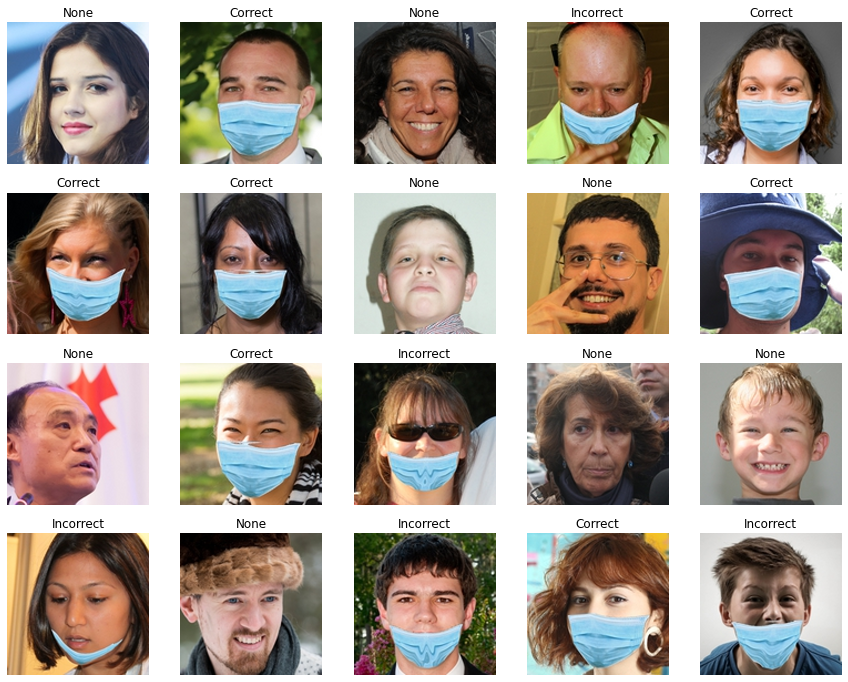

In [9]:
plt.subplots(figsize=(15,12))
for s in range(20):
    plt.subplot(4, 5, s+1)
    plt.title(y_test_smsample[s][0], fontsize=12)
    plt.imshow(X_test_smsample[s], interpolation='spline16')
    plt.axis('off')
plt.show()

### Training the CNN Base Model
***Optional***

In [10]:
%%time
base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(768, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Base_MaskedFaceNet_Model')

base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CNN_Base_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 14, 14, 64)        0         
_______________________

In [617]:
%%time
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,\
                                patience=3, restore_best_weights=True) 

base_model.fit(X_train, ohe.transform(y_train), validation_split=0.2,\
               batch_size=128, callbacks=[es], epochs=30, verbose=1)

_, accuracy_test = base_model.evaluate(X_test, ohe.transform(y_test))
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

tostring() is deprecated. Use tobytes() instead.


Train on 16800 samples, validate on 4200 samples
Epoch 1/30
16800/16800 [==============================] - 54s 3ms/sample - loss: 0.1584 - accuracy: 0.9399 - val_loss: 0.0276 - val_accuracy: 0.9948
Epoch 2/30
16800/16800 [==============================] - 55s 3ms/sample - loss: 0.0219 - accuracy: 0.9952 - val_loss: 0.0303 - val_accuracy: 0.9936
Epoch 3/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.0221 - val_accuracy: 0.9957
Epoch 4/30
16800/16800 [==============================] - 55s 3ms/sample - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.0222 - val_accuracy: 0.9962
Epoch 5/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.0235 - val_accuracy: 0.9962
Epoch 6/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0125 - accuracy: 0.9975 - val_loss: 0.0201 - val_accuracy: 0.9955
Epoch 7/30
16800/16800 [==============================] -

### Loading the CNN Base Model

In [10]:
%%time
model_path = get_file('CNN_Base_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Base_MaskedFace_Net.hdf5?raw=true')
base_model = tf.keras.models.load_model(model_path)
base_model.summary()

2022-11-23 10:44:38.830762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "CNN_Base_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12

### Assessing the CNN Base Classifier

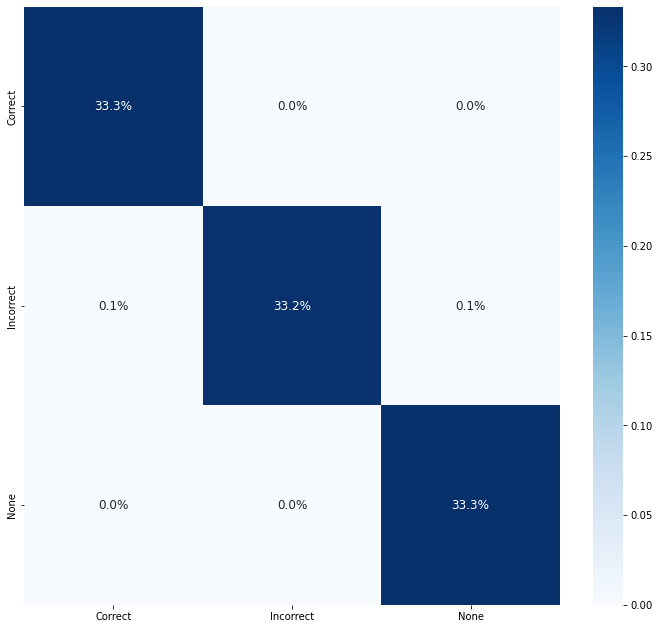

              precision    recall  f1-score   support

     Correct      0.998     0.998     0.998      1400
   Incorrect      0.999     0.995     0.997      1400
        None      0.996     0.999     0.998      1400

    accuracy                          0.997      4200
   macro avg      0.997     0.997     0.997      4200
weighted avg      0.997     0.997     0.997      4200



In [11]:
y_test_pred, y_test_prob = mldatasets.evaluate_multiclass_mdl(base_model, X_test, y_test, labels_l, ohe,\
                                                    plot_conf_matrix=True, predopts={"verbose":1})

## Learning about Evasion Attacks

In [12]:
%%time
base_classifier = KerasClassifier(model=base_model, clip_values=(min_, max_))
y_test_mdsample_prob = np.max(y_test_prob[sampl_md_idxs], axis=1)
y_test_smsample_prob = np.max(y_test_prob[sampl_sm_idxs], axis=1)

CPU times: user 109 ms, sys: 29.8 ms, total: 139 ms
Wall time: 151 ms


### Fast Gradient Sign Method Attack

In [13]:
%%time
attack_fgsm = FastGradientMethod(base_classifier, eps=0.1)

CPU times: user 91 µs, sys: 250 µs, total: 341 µs
Wall time: 346 µs


In [14]:
%%time
X_test_fgsm = attack_fgsm.generate(X_test_mdsample)

CPU times: user 5.17 s, sys: 2.33 s, total: 7.5 s
Wall time: 7.23 s


In [15]:
%%time
y_test_fgsm_pred, y_test_fgsm_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_fgsm, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_prob = np.max(y_test_fgsm_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.056     0.014     0.023        70
   Incorrect      0.220     0.370     0.276        54
        None      0.736     0.882     0.802        76

    accuracy                          0.440       200
   macro avg      0.337     0.422     0.367       200
weighted avg      0.359     0.440     0.387       200

CPU times: user 1.02 s, sys: 161 ms, total: 1.19 s
Wall time: 386 ms


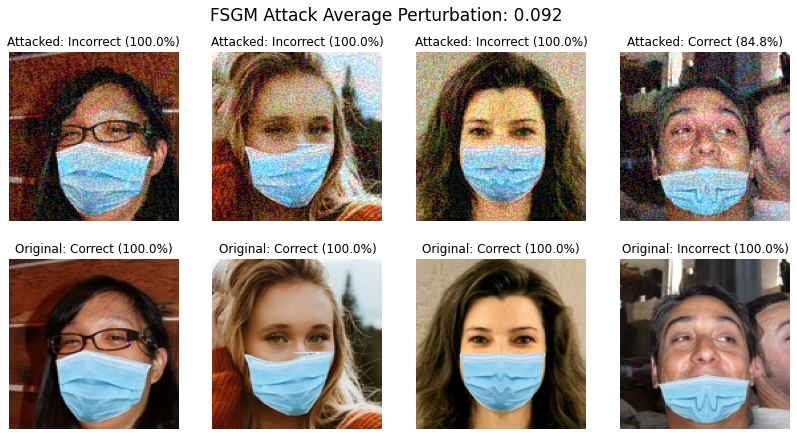

CPU times: user 654 ms, sys: 195 ms, total: 849 ms
Wall time: 752 ms


In [16]:
%%time
mldatasets.compare_image_predictions(X_test_fgsm, X_test_mdsample, y_test_fgsm_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

### Carlini & Wagner Infinity-norm Attack

In [17]:
%%time
attack_cw = CarliniLInfMethod(base_classifier, batch_size=40)
X_test_cw = attack_cw.generate(X_test_mdsample)


CPU times: user 36min 11s, sys: 5min 57s, total: 42min 9s
Wall time: 23min 14s


In [18]:
%%time
y_test_cw_pred, y_test_cw_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_cw, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_cw_prob = np.max(y_test_cw_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.895     0.729     0.803        70
   Incorrect      0.653     0.907     0.760        54
        None      0.985     0.882     0.931        76

    accuracy                          0.835       200
   macro avg      0.844     0.839     0.831       200
weighted avg      0.864     0.835     0.840       200

CPU times: user 1.16 s, sys: 234 ms, total: 1.39 s
Wall time: 499 ms


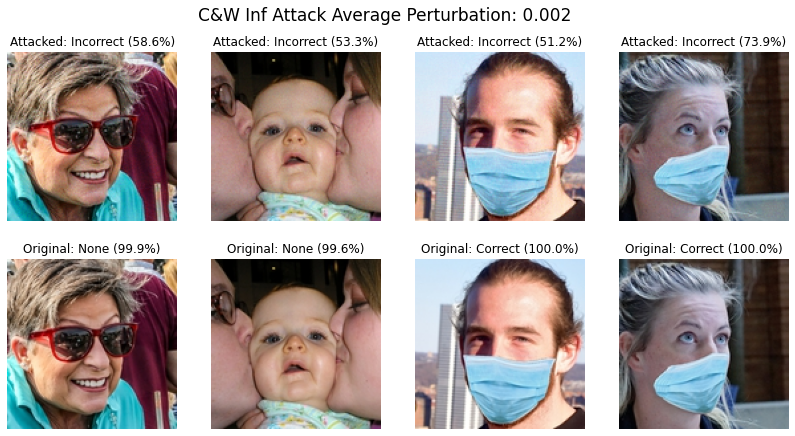

CPU times: user 657 ms, sys: 305 ms, total: 962 ms
Wall time: 981 ms


In [19]:
%%time
mldatasets.compare_image_predictions(X_test_cw, X_test_mdsample, y_test_cw_pred,\
                                     y_test_mdsample.flatten(), y_test_cw_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="C&W Inf Attack Average Perturbation: ",\
                                     num_samples=4)

### Targeted Adversarial Patch Attack

In [20]:
%%time
attack_ap = AdversarialPatchNumpy(base_classifier, scale_min=0.4, scale_max=0.7,\
                                  learning_rate=5., max_iter=500, batch_size=40,\
                                  target=0)

CPU times: user 1.08 ms, sys: 4.08 ms, total: 5.16 ms
Wall time: 14 ms


In [21]:
%%time
placement_mask = np.zeros((128,128))
placement_mask[80:93,45:83] = 1
placement_mask = np.expand_dims(placement_mask, axis=0).astype(bool)

patch, patch_mask = attack_ap.generate(x=X_test_smsample,\
                                       y=ohe.transform(y_test_smsample),\
                                       mask=placement_mask)


CPU times: user 6min 11s, sys: 46.4 s, total: 6min 57s
Wall time: 4min 41s


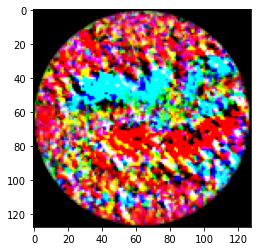

In [22]:
plt.imshow(patch * patch_mask)
plt.show()

In [23]:
%%time
X_test_ap = attack_ap.apply_patch(X_test_smsample, scale=0.55, mask=placement_mask)

CPU times: user 272 ms, sys: 10.2 ms, total: 283 ms
Wall time: 283 ms


In [24]:
%%time
y_test_ap_pred, y_test_ap_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_ap, y_test_smsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_ap_prob = np.max(y_test_ap_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.400     0.286     0.333         7
   Incorrect      0.364     0.800     0.500         5
        None      0.500     0.250     0.333         8

    accuracy                          0.400        20
   macro avg      0.421     0.445     0.389        20
weighted avg      0.431     0.400     0.375        20

CPU times: user 105 ms, sys: 35.3 ms, total: 140 ms
Wall time: 35.3 ms


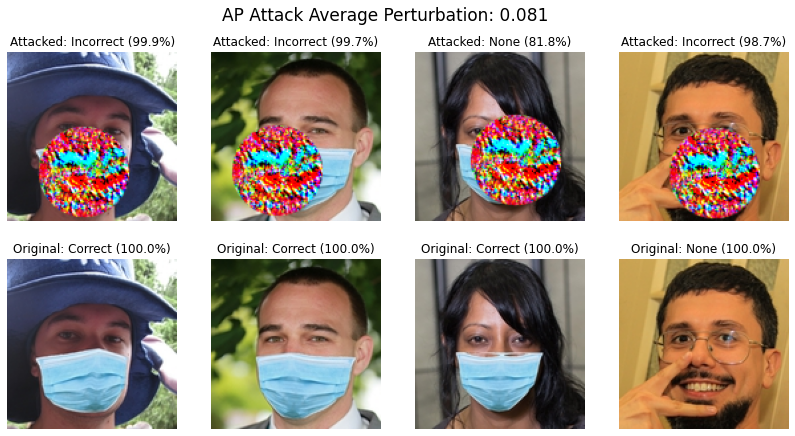

CPU times: user 519 ms, sys: 83.4 ms, total: 603 ms
Wall time: 435 ms


In [25]:
%%time
mldatasets.compare_image_predictions(X_test_ap, X_test_smsample, y_test_ap_pred,\
                                     y_test_smsample.flatten(), y_test_ap_prob,\
                                     y_test_smsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="AP Attack Average Perturbation: ",\
                                     num_samples=4)

## Defending Against Targeted Attacks with Preprocessing

In [26]:
%%time
not_masked_idxs = np.where(y_test_smsample != 'Correct')[0]
X_test_notmasked = X_test_smsample[not_masked_idxs]
y_test_notmasked = y_test_smsample[not_masked_idxs]
y_test_notmasked_prob = y_test_smsample_prob[not_masked_idxs]
y_test_masked = np.array(['Correct'] * X_test_notmasked.shape[0]).reshape(-1,1)

CPU times: user 1.97 ms, sys: 1.86 ms, total: 3.83 ms
Wall time: 2.77 ms


In [27]:
%%time
attack_pgd = ProjectedGradientDescent(base_classifier, eps=0.3, eps_step=0.01, max_iter=40,\
                                      targeted=True)
X_test_pgd = attack_pgd.generate(X_test_notmasked,\
                                 y=ohe.transform(y_test_masked))


CPU times: user 8.33 s, sys: 1.57 s, total: 9.9 s
Wall time: 3.31 s


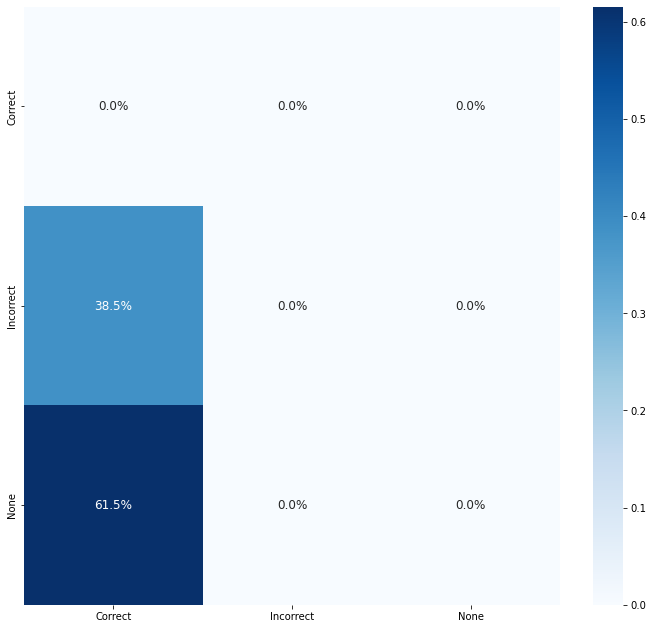

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000       0.0
   Incorrect      0.000     0.000     0.000       5.0
        None      0.000     0.000     0.000       8.0

    accuracy                          0.000      13.0
   macro avg      0.000     0.000     0.000      13.0
weighted avg      0.000     0.000     0.000      13.0

CPU times: user 355 ms, sys: 82.6 ms, total: 437 ms
Wall time: 212 ms


In [28]:
%%time
y_test_pgd_pred, y_test_pgd_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=True, plot_roc=False)
y_test_pgd_prob = np.max(y_test_pgd_prob, axis=1)

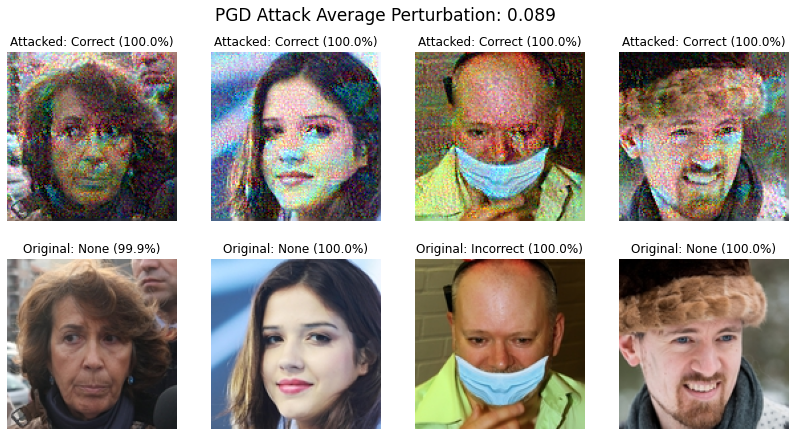

CPU times: user 808 ms, sys: 688 ms, total: 1.5 s
Wall time: 1.66 s


In [29]:
%%time
mldatasets.compare_image_predictions(X_test_pgd, X_test_notmasked, y_test_pgd_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_prob, y_test_smsample_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ")

In [30]:
%%time
defence_ss = SpatialSmoothing(window_size=11)
X_test_pgd_ss, _ = defence_ss(X_test_pgd)

CPU times: user 881 ms, sys: 3.73 ms, total: 885 ms
Wall time: 885 ms


In [31]:
%%time
y_test_pgd_ss_pred, y_test_pgd_ss_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd_ss, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_pgd_ss_prob = np.max(y_test_pgd_ss_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000         0
   Incorrect      1.000     0.600     0.750         5
        None      0.750     0.375     0.500         8

    accuracy                          0.462        13
   macro avg      0.583     0.325     0.417        13
weighted avg      0.846     0.462     0.596        13

CPU times: user 75.9 ms, sys: 22.2 ms, total: 98.2 ms
Wall time: 21.9 ms


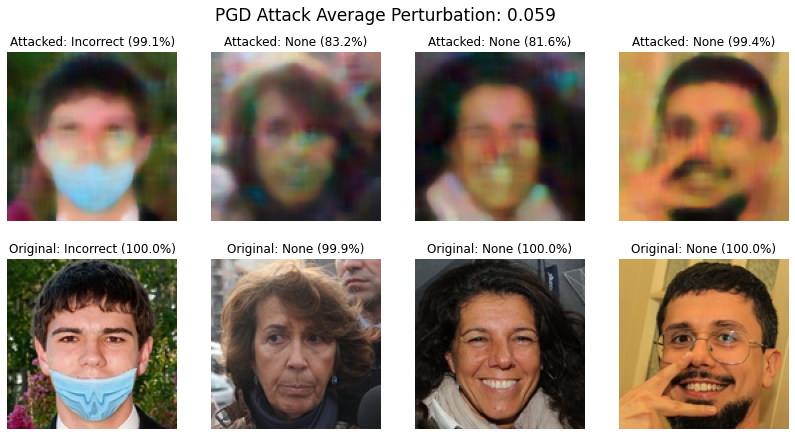

CPU times: user 512 ms, sys: 71.6 ms, total: 583 ms
Wall time: 408 ms


In [32]:
%%time
mldatasets.compare_image_predictions(X_test_pgd_ss, X_test_notmasked, y_test_pgd_ss_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_ss_prob, y_test_notmasked_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ",\
                                     use_misclass=False)

## Shielding Against Any Evasion Attack by Adversarial Training of a Robust Classifier

### Training the CNN Robust Model
***Optional***

In [210]:
%%time
robust_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Robust_MaskedFaceNet_Model')

robust_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

robust_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 32)       

In [218]:
%%time
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=20)
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=0.5)
trainer.fit(X_train, ohe.transform(y_train), nb_epochs=30, batch_size=128)

Adversarial training epochs: 100%|██████████| 30/30 [8:23:54<00:00, 1007.83s/it]  

CPU times: user 1d 21h 40min 50s, sys: 3h 53min 11s, total: 2d 1h 34min 1s
Wall time: 8h 23min 54s


### Loading the CNN Robust Model

In [33]:
%%time
model_path = get_file('CNN_Robust_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Robust_MaskedFace_Net.hdf5?raw=true')
robust_model = tf.keras.models.load_model(model_path)
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))

CPU times: user 714 ms, sys: 129 ms, total: 843 ms
Wall time: 842 ms


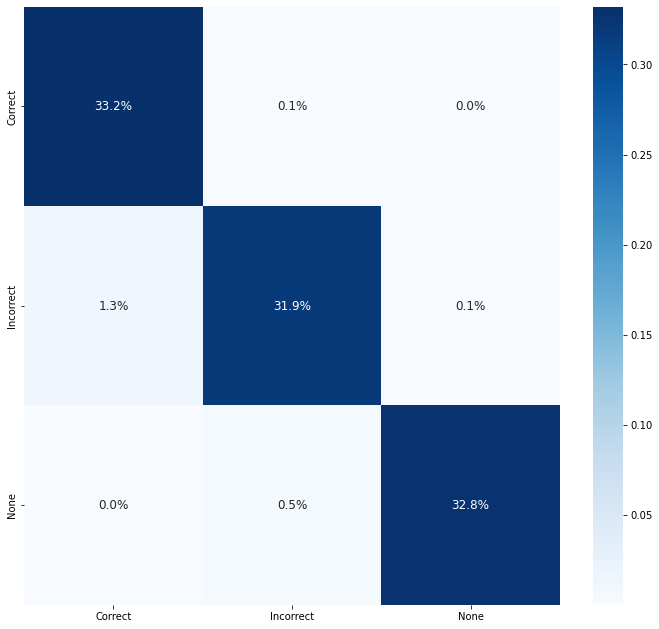

              precision    recall  f1-score   support

     Correct      0.962     0.996     0.979      1400
   Incorrect      0.980     0.957     0.969      1400
        None      0.994     0.983     0.989      1400

    accuracy                          0.979      4200
   macro avg      0.979     0.979     0.979      4200
weighted avg      0.979     0.979     0.979      4200



In [34]:
y_test_robust_pred, y_test_robust_prob =\
                mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test, y_test,\
                                                   labels_l, ohe, plot_conf_matrix=True,\
                                                   predopts={"verbose":1})

### Assessing the CNN Robust Classifier

In [35]:
%%time
attack_fgsm_robust = FastGradientMethod(robust_classifier, eps=0.1)
X_test_fgsm_robust = attack_fgsm_robust.generate(X_test_mdsample)

CPU times: user 5.07 s, sys: 1.3 s, total: 6.37 s
Wall time: 2.02 s


In [36]:
%%time
y_test_fgsm_robust_pred, y_test_fgsm_robust_prob =\
    mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test_fgsm_robust, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_robust_prob = np.max(y_test_fgsm_robust_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.921     1.000     0.959        70
   Incorrect      0.942     0.907     0.925        54
        None      1.000     0.947     0.973        76

    accuracy                          0.955       200
   macro avg      0.954     0.952     0.952       200
weighted avg      0.957     0.955     0.955       200

CPU times: user 1.23 s, sys: 133 ms, total: 1.36 s
Wall time: 329 ms


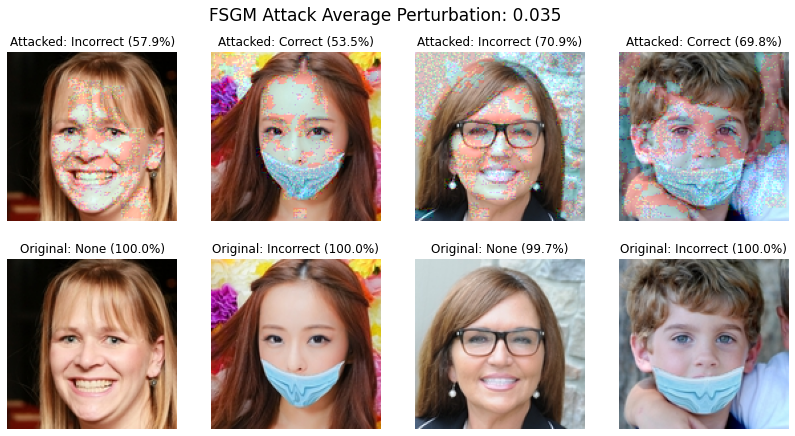

CPU times: user 608 ms, sys: 134 ms, total: 742 ms
Wall time: 573 ms


In [37]:
%%time
mldatasets.compare_image_predictions(X_test_fgsm_robust, X_test_mdsample, y_test_fgsm_robust_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_robust_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

## Evaluating Adversarial Robustness

### Comparing Model Robustness with Attack Strength

In [38]:
accuracy_base_0 = metrics.accuracy_score(y_test, y_test_pred)
accuracy_robust_0 = metrics.accuracy_score(y_test, y_test_robust_pred)

In [39]:
eps_range = np.concatenate((np.linspace(0.01, 0.09, 9),\
                            np.linspace(0.1, 0.9, 9)), axis=0).tolist()

In [40]:
%%time
accuracy_base = [accuracy_base_0]
accuracy_robust = [accuracy_robust_0]
for eps in tqdm(eps_range, desc='EPS'):
    attack_fgsm.set_params(**{'eps': eps})
    X_test_fgsm_base_i = attack_fgsm.generate(X_test_mdsample)
    _, accuracy_base_i = base_classifier.model.evaluate(X_test_fgsm_base_i,\
                                            ohe.transform(y_test_mdsample))
    
    attack_fgsm_robust.set_params(**{'eps': eps})
    X_test_fgsm_robust_i = attack_fgsm_robust.generate(X_test_mdsample)
    _, accuracy_robust_i = robust_classifier.model.evaluate(X_test_fgsm_robust_i,\
                                            ohe.transform(y_test_mdsample))
    
    accuracy_base.append(accuracy_base_i)
    accuracy_robust.append(accuracy_robust_i)
    
eps_range = [0] + eps_range


CPU times: user 3min 50s, sys: 42.7 s, total: 4min 33s
Wall time: 1min 18s


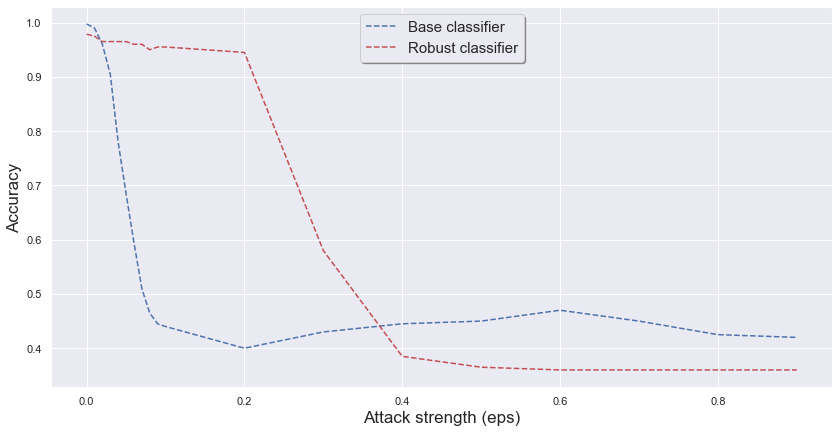

In [41]:
sns.set()
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.array(eps_range), np.array(accuracy_base), 'b--', label='Base classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')
legend = ax.legend(loc='upper center', shadow=True, fontsize=15)
plt.xlabel('Attack strength (eps)', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.show()